In [5]:
%pylab inline
from qsystem_2 import PfbSoc, freq2reg
from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
#from averager_program import AveragerProgram
#from slab.instruments import InstrumentManager
import time

Populating the interactive namespace from numpy and matplotlib


In [6]:
soc = PfbSoc('qsystem_2.bit')

In [10]:
fout = 1090

with ASM_Program() as p:
    fout = p.reg2freq_adc(p.freq2reg_adc(fout))
    print (fout)
    
    p.add_pulse(ch=1, name="gauss",  style="flat_top", idata=gauss(mu=25*16, si=10*16, length=50*16, maxv=2**15-1), qdata=None, length=10)
    #p.add_pulse(ch=7, name="gauss",  style="const", idata=gauss(mu=25*16, si=200, length=50*16, maxv=2**15-1), qdata=None, length=2*10+50)
    
    p.pulse(ch=1, pulse="gauss", freq=p.freq2reg(fout), phase=0, gain=20000, t=0, play=False)
    p.synci(200)
    
    p.regwi(0,4, 4)
    
    p.trigger_adc(adc1=1, adc2=1,adc_trig_offset=206)
    p.label("LOOP")
    p.pulse(1,play=True)
    
    p.sync_all(t=100)
    p.loopnz (0,4,"LOOP")
    
    p.waiti(0,1000)
    p.read (0,3,"lower", 1) #Lower 32-bit on register $1 of page 3.
    p.read (0,3,"upper", 2)
    
    p.memwi (3,1,55)
    p.memwi (3,2,56)
    
    p.end()
p

1089.984375



// Program

      regwi 0, $16, 761954304;                  //freq = 1089.984375 MHz
      regwi 0, $17, 0;                          //phase = 0
      regwi 0, $19, 20000;                      //gain = 20000
      regwi 0, $21, 0;                          //t = 0
      regwi 0, $18, 0;                          //addr = 0
      regwi 0, $20, 524313;                     //stdysel | mode | outsel = 0b01000 | length = 25 
      synci 200;
      regwi 0, $4, 4;
      regwi 0, $31, 49152;                      //out = 0b1100000000000000
      seti 0, 0, $31, 206;                      //ch =0 out = $31 @t = 0
      regwi 0, $31, 0;                          //out = 0b0000000000000000
      seti 0, 0, $31, 216;                      //ch =0 out = $31 @t = 0
LOOP: regwi 0, $19, 20000;                      //gain = 20000
      regwi 0, $21, 0;                          //t = 0
      regwi 0, $18, 0;                          //addr = 0
      regwi 0, $20, 524313;                     //stdysel | mode

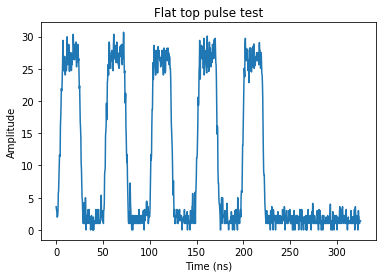

In [12]:
p.load_pulses(soc)

soc.tproc.stop()
soc.tproc.load_asm_program(p)
readout_length=1000

soc.readouts[0].set_out("product")
soc.readouts[0].set_freq(fout)
soc.avg_bufs[0].config(address=0, length=readout_length)
soc.avg_bufs[0].enable()

soc.readouts[1].set_out("product")
soc.readouts[1].set_freq(fout)
soc.avg_bufs[1].config(address=0, length=readout_length)
soc.avg_bufs[1].enable()


# Start tProc.

soc.tproc.start()

time.sleep(.001)

# Raw data.
[di_raw,dq_raw] = soc.get_decimated(ch=1, length=readout_length)
#plt.plot(di_raw)
#plt.plot(dq_raw)
tpts=arange(readout_length)/soc.fs_adc*1000
plt.subplot(111, xlabel="Time (ns)", ylabel="Amplitude", title="Flat top pulse test")
plt.plot(tpts,np.sqrt(di_raw**2+dq_raw**2))



# Accumulated data.
[di,dq] = soc.get_accumulated(ch=0, length=16)